# SingleCell Data Analysis on the CPU with Pearson Residuals
**Author:** [Severin Dicks](https://github.com/Intron7) (IBSM Freiburg)

To run this notebook please make sure you have a working enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of 200000 brain cells from  [Nvidia](https://github.com/clara-parabricks/rapids-single-cell-examples/blob/master/notebooks/1M_brain_cpu_analysis.ipynb).

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time


import matplotlib.pyplot as plt
from matplotlib import rcParams

sc.set_figure_params(dpi= 80, dpi_save = 300)
rcParams['figure.figsize'] = 5,5

sc._settings.ScanpyConfig.n_jobs = 60

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. 

In [2]:
data_load_start = time.time()

In [3]:
%%time
adata=sc.read("h5/200000.h5ad")

CPU times: user 228 ms, sys: 428 ms, total: 656 ms
Wall time: 656 ms


In [4]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 0.6622655391693115


## Preprocessing

In [5]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

Some genes will now have zero expression in all cells. We filter out such genes.

In [6]:
%%time
adata.var['MT'] = adata.var_names.str.startswith('mt-') 

CPU times: user 6.42 ms, sys: 0 ns, total: 6.42 ms
Wall time: 6.09 ms


In [7]:
%%time
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

CPU times: user 4.76 s, sys: 239 ms, total: 5 s
Wall time: 4.99 s


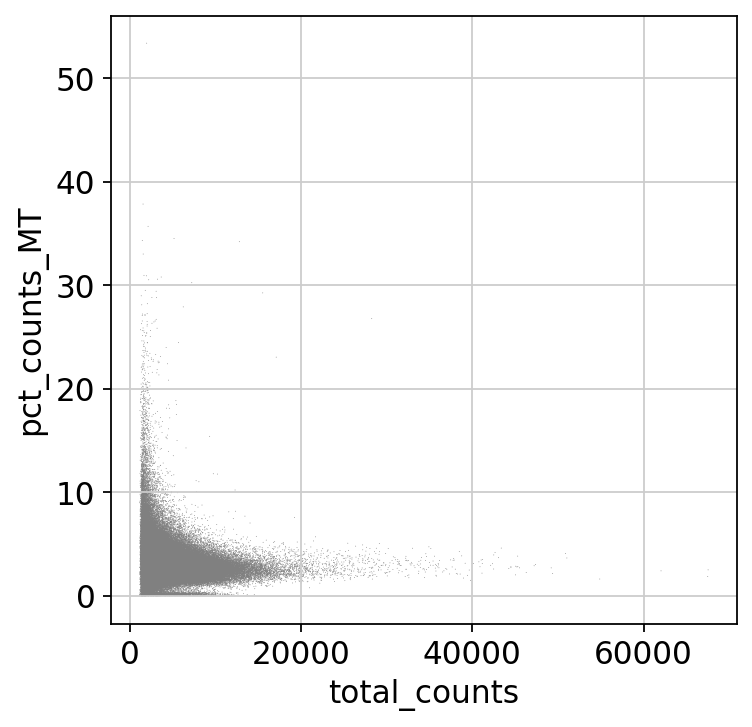

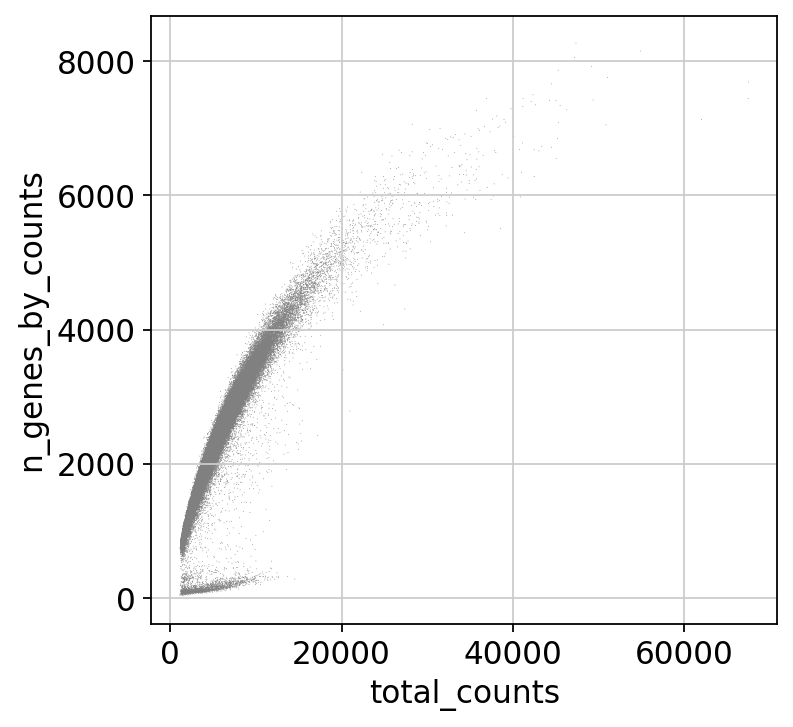

In [8]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

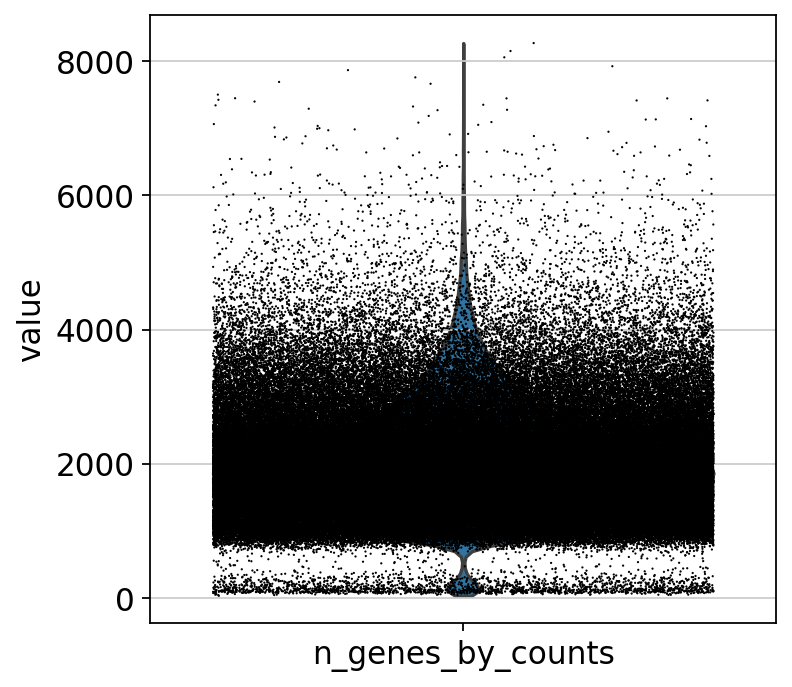

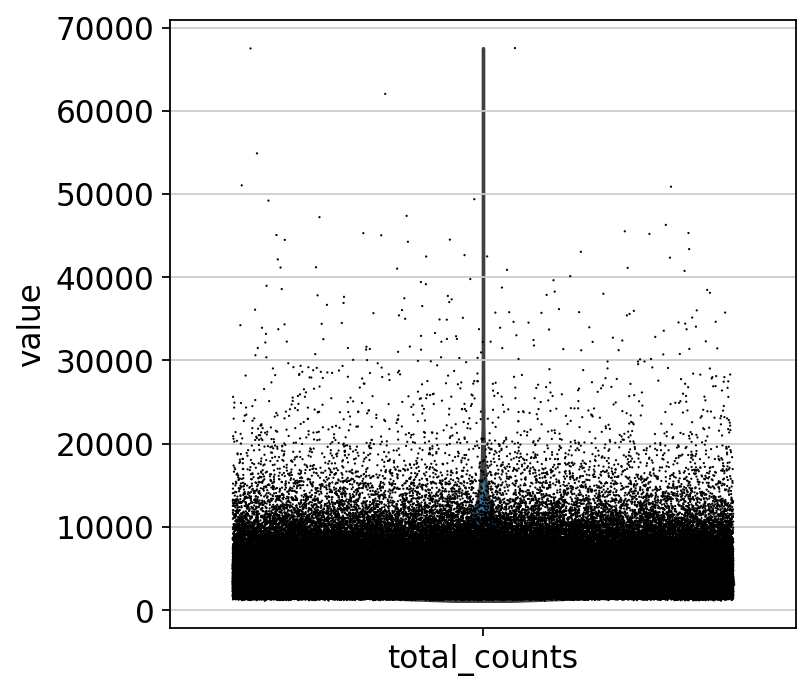

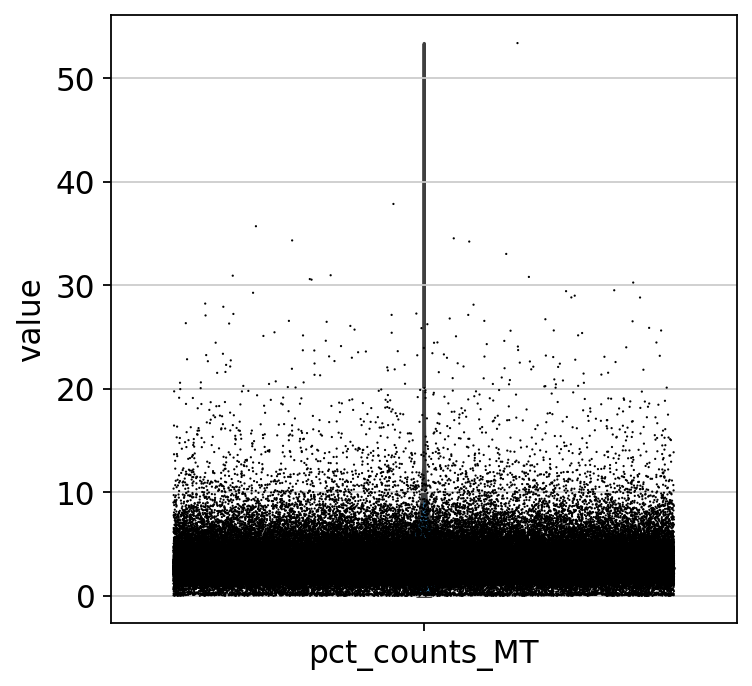

In [9]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4)
sc.pl.violin(adata, 'total_counts',jitter=0.4)
sc.pl.violin(adata, 'pct_counts_MT',jitter=0.4)


### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

The size of our count matrix is now reduced.

In [10]:
%%time
adata = adata[adata.obs.n_genes_by_counts > 200, :]
adata = adata[adata.obs.pct_counts_MT < 20, :].copy()

CPU times: user 316 ms, sys: 403 ms, total: 719 ms
Wall time: 718 ms


We copy the raw counts to the layer `counts`

In [12]:
adata.layers["counts"] = adata.X.copy()

In [13]:
adata.shape

(198371, 20865)

### Log-Normalize counts

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [14]:
%%time
sc.pp.normalize_total(adata,target_sum=1e4)

CPU times: user 938 ms, sys: 128 ms, total: 1.07 s
Wall time: 1.06 s


Next, we log transform the count matrix.

In [15]:
%%time
sc.pp.log1p(adata)

CPU times: user 3.71 s, sys: 0 ns, total: 3.71 s
Wall time: 3.71 s


We store this log normalized expression as `.raw`

In [16]:
%%time
adata.raw = adata

CPU times: user 138 ms, sys: 199 ms, total: 337 ms
Wall time: 335 ms


We restore raw counts to `.X`

In [17]:
adata.X = adata.layers["counts"]

### Select Most Variable Genes

We will now select the most variable genes in the dataset based on `pearson_residuals`.

In [18]:
%%time
sc.experimental.pp.highly_variable_genes(adata,flavor="pearson_residuals",n_top_genes=3000)

CPU times: user 33.2 s, sys: 14.8 s, total: 47.9 s
Wall time: 47.9 s


Restrict adata to only the highly variable genes

In [19]:
%%time
adata = adata[:, adata.var.highly_variable].copy()

CPU times: user 3.06 s, sys: 543 ms, total: 3.6 s
Wall time: 3.6 s


In [20]:
adata.shape

(198371, 3000)

We will normalize the most variable genes in the dataset based on `pearson_residuals`.

In [21]:
%%time
sc.experimental.pp.normalize_pearson_residuals(adata)

CPU times: user 3.81 s, sys: 1.96 s, total: 5.78 s
Wall time: 5.78 s


Next we regess out effects of counts per cell and the mitochondrial content of the cells. 

In [22]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 85.52429008483887


## Clustering and Visulization

### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. 

In [24]:
%%time
sc.tl.pca(adata, n_comps = 100)

CPU times: user 48min 32s, sys: 9min 43s, total: 58min 16s
Wall time: 32.5 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

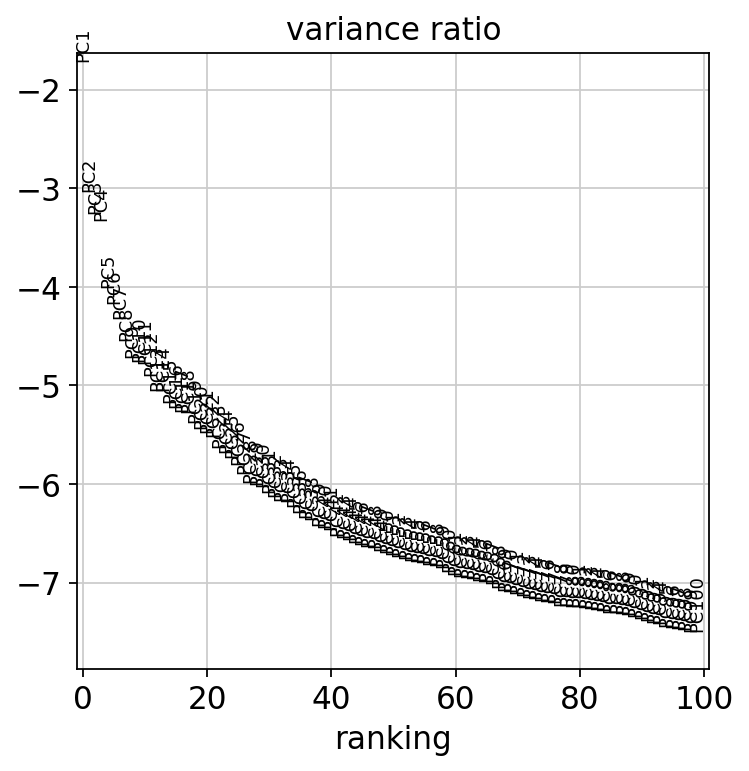

In [25]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph and UMAP

In [26]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

CPU times: user 2min 22s, sys: 11min 54s, total: 14min 17s
Wall time: 35.4 s


In [27]:
%%time
sc.tl.umap(adata)

CPU times: user 36min 32s, sys: 30min 35s, total: 1h 7min 8s
Wall time: 1min 39s


### Clustering
We cluster the cells with the Leiden and Louvain algorithm

In [28]:
%%time
sc.tl.louvain(adata)

CPU times: user 1min 28s, sys: 484 ms, total: 1min 28s
Wall time: 1min 28s


In [29]:
%%time
sc.tl.leiden(adata)

IOStream.flush timed out
IOStream.flush timed out


CPU times: user 1min 51s, sys: 753 ms, total: 1min 52s
Wall time: 1min 51s


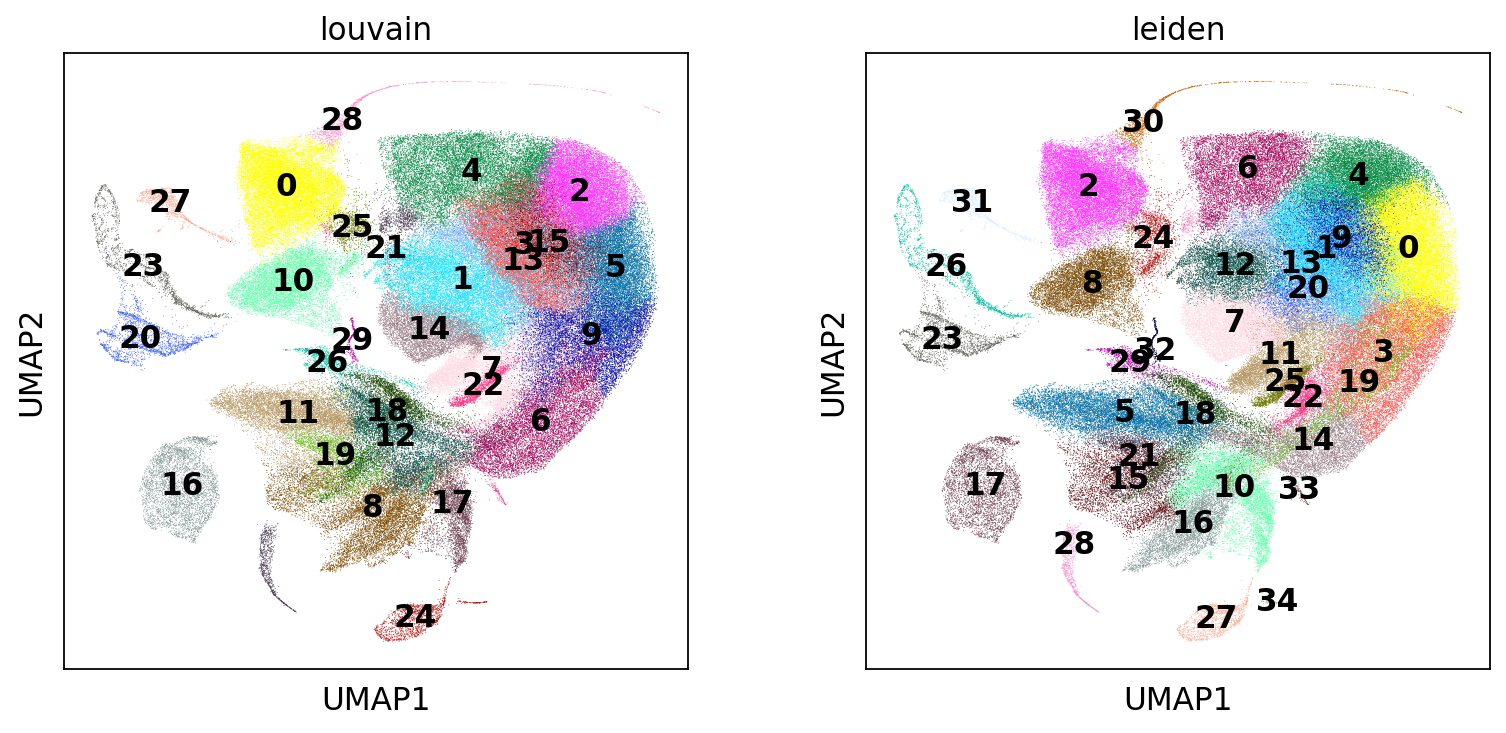

CPU times: user 1.75 s, sys: 193 ms, total: 1.95 s
Wall time: 1.75 s


In [30]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

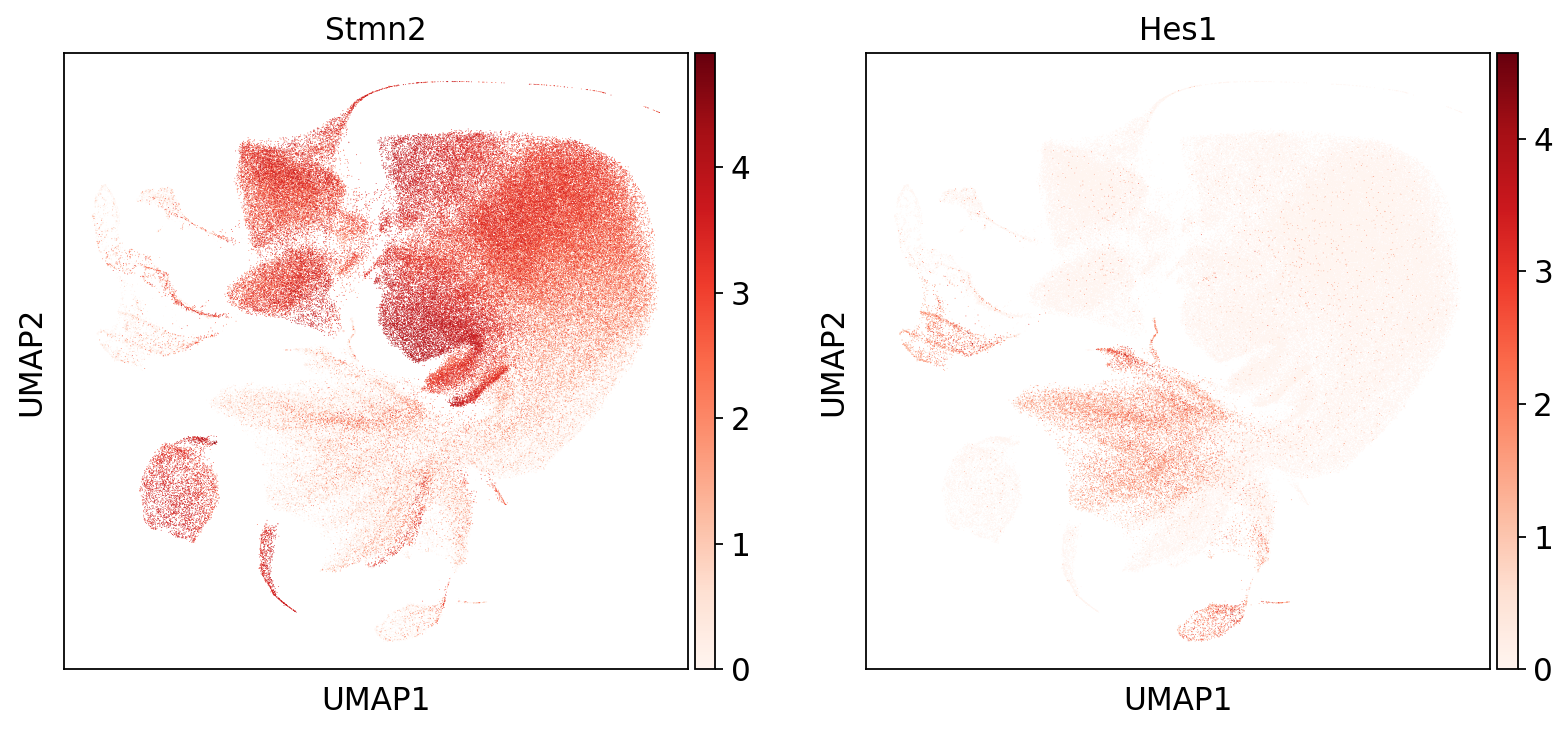

CPU times: user 1.71 s, sys: 173 ms, total: 1.88 s
Wall time: 1.65 s


In [31]:
%%time
sc.pl.umap(adata, color=["Stmn2","Hes1"],legend_loc = 'on data', cmap="Reds")

In [32]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 494.86015582084656
